## Amey train station project

Contents:

1) Data Loading and file handling

### 1) Data Loading and File Handling

First we need to load the provided data into this environment in the form of a dataframe, converting it from excel format.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from numpy.linalg import norm
from datetime import datetime, timedelta
from prophet import Prophet

c:\Users\suhai\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [ ]:
df = pd.read_excel('StationFootfall_2024_2025.xlsx')
df.head()

,TravelDate,DayOfWeek,Station,EntryTapCount,ExitTapCount
0,20240101,Monday,Abbey Road DLR,395,375
1,20240101,Monday,Abbey Wood,5898,5963
2,20240101,Monday,Acton Central,609,474
3,20240101,Monday,Acton Main Line,1717,1710
4,20240101,Monday,Acton Town,2928,3334


In [3]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299860 entries, 0 to 299859
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   TravelDate     299860 non-null  int64 
 1   DayOfWeek      299860 non-null  object
 2   Station        299860 non-null  object
 3   EntryTapCount  299860 non-null  int64 
 4   ExitTapCount   299860 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.4+ MB


,TravelDate,EntryTapCount,ExitTapCount
count,2.998600e+05,299860.000000,299860.000000
mean,2.024541e+07,9041.877580,9016.105646
std,4.980014e+03,13991.613098,14222.726088
min,2.024010e+07,0.000000,0.000000
25%,2.024062e+07,2321.000000,2216.000000
50%,2.024121e+07,4657.000000,4517.000000
75%,2.025061e+07,9159.000000,9091.000000
max,2.025113e+07,141979.000000,142751.000000


In [4]:
# Now we will be converting the TravelDate to datetime format.
df['TravelDate'] = pd.to_datetime(df['TravelDate'].astype(str), format="%Y%m%d")
df.head()

,TravelDate,DayOfWeek,Station,EntryTapCount,ExitTapCount
0,2024-01-01,Monday,Abbey Road DLR,395,375
1,2024-01-01,Monday,Abbey Wood,5898,5963
2,2024-01-01,Monday,Acton Central,609,474
3,2024-01-01,Monday,Acton Main Line,1717,1710
4,2024-01-01,Monday,Acton Town,2928,3334


In [5]:
df = df.sort_values(['Station', 'TravelDate'])
df.head()

,TravelDate,DayOfWeek,Station,EntryTapCount,ExitTapCount
0,2024-01-01,Monday,Abbey Road DLR,395,375
433,2024-01-02,Tuesday,Abbey Road DLR,689,661
866,2024-01-03,Wednesday,Abbey Road DLR,781,797
1300,2024-01-04,Thursday,Abbey Road DLR,859,848
1734,2024-01-05,Friday,Abbey Road DLR,844,783


In [6]:
print(df.isna().sum())

TravelDate       0
DayOfWeek        0
Station          0
EntryTapCount    0
ExitTapCount     0
dtype: int64


In [7]:
df.Station.nunique(),df['TravelDate'].min(),df['TravelDate'].max()

(437, Timestamp('2024-01-01 00:00:00'), Timestamp('2025-11-29 00:00:00'))

From the above 2 lines of code we see that there are no empty values within the provided data, and so no cleaning is required. We also see that there are 437 different stations within this data set and that the dates provided in the data match the description of teh dataset.

### 2) Feature Engineering for Clustering

Now I will create a feature matrix for each station for clustering later on. The matrix will contain characteristics like the average daily click in/out values, weekend vs weekday values etc.

Computing day of the week average entries and exits per station:  

In [8]:
entry_pivot = df.pivot_table(index='Station',
                       columns='DayOfWeek',
                       values='EntryTapCount',
                       aggfunc = 'mean'
                    )
entry_pivot.columns = [f"EntryAvg_{c}" for c in entry_pivot.columns]
entry_pivot.head()

,EntryAvg_Friday,EntryAvg_Monday,EntryAvg_Saturday,EntryAvg_Sunday,EntryAvg_Thursday,EntryAvg_Tuesday,EntryAvg_Wednesday
Station,,,,,,,
Abbey Road DLR,969.740000,858.080000,609.010638,467.285714,988.010000,959.19,962.290000
Abbey Wood,16885.510000,15792.370000,13587.820000,9132.090909,18454.484848,18016.17,18094.676768
Acton Central,2414.410000,2090.750000,1916.252525,1044.357143,2437.444444,2383.43,2384.646465
Acton Main Line,4215.387755,3821.494949,3681.346939,2084.630137,4614.020202,4298.65,4392.686869
Acton Town,7534.270000,6583.940000,6090.806122,4528.701031,7647.040000,7471.42,7558.444444


In [9]:
exit_pivot = df.pivot_table(index='Station',
                       columns='DayOfWeek',
                       values='ExitTapCount',
                       aggfunc = 'mean'
                    )
exit_pivot.columns = [f"ExitAvg_{c}" for c in exit_pivot.columns]
exit_pivot.head()

,ExitAvg_Friday,ExitAvg_Monday,ExitAvg_Saturday,ExitAvg_Sunday,ExitAvg_Thursday,ExitAvg_Tuesday,ExitAvg_Wednesday
Station,,,,,,,
Abbey Road DLR,876.790000,808.640000,543.021277,438.681319,922.730000,894.65,894.860000
Abbey Wood,15330.690000,14958.480000,12024.850000,8450.131313,17367.020202,17087.18,17211.141414
Acton Central,2274.200000,2048.390000,1827.777778,1041.765306,2357.909091,2332.11,2326.868687
Acton Main Line,3825.561224,3762.727273,3185.897959,2007.342466,4425.393939,4240.11,4249.555556
Acton Town,7620.280000,6828.220000,6483.408163,4968.371134,7729.030000,7633.41,7650.010101


Now we will be computing overall averages and total counts per station. These features will capture scale, and clustering will use them to distinguish big interchanges from local train stations.

In [10]:
station_overall = df.groupby('Station').agg(
    AvgEntry =('EntryTapCount', 'mean'),
    AvgExit = ('ExitTapCount', 'mean'),
    TotalEntry = ('EntryTapCount', 'sum'),  
    TotalExit = ('ExitTapCount', 'sum')
)

station_overall.head()

,AvgEntry,AvgExit,TotalEntry,TotalExit
Station,,,,
Abbey Road DLR,837.227737,774.789781,573501,530731
Abbey Wood,15711.091822,14634.032999,10950631,10199921
Acton Central,2098.276259,2032.094964,1458302,1412306
Acton Main Line,3942.815315,3737.237237,2625915,2489000
Acton Town,6784.057637,6996.759366,4708136,4855751


Now we will take a look at weekday vs weekend behaviour:

In [11]:
df['IsWeekend'] = df['DayOfWeek'].isin(['Saturday', 'Sunday'])

week_stats = df.groupby(['Station', 'IsWeekend'])[['EntryTapCount', 'ExitTapCount']].mean().unstack('IsWeekend')

week_stats.columns = [
    f"{col[0]}_{'Weekend' if col[1] else 'Weekday'}"
    for col in week_stats.columns
]


display(week_stats.shape)
week_stats.head()

(437, 4)

,EntryTapCount_Weekday,EntryTapCount_Weekend,ExitTapCount_Weekday,ExitTapCount_Weekend
Station,,,,
Abbey Road DLR,947.462000,539.297297,879.534000,491.697297
Abbey Wood,17445.325301,11371.150754,16387.295181,10246.472362
Acton Central,2341.859438,1482.517766,2267.596386,1436.766497
Acton Main Line,4268.616162,2999.707602,4101.507071,2682.771930
Acton Town,7358.623246,5313.758974,7491.873747,5729.774359


Now we will be combining all of these key statistics into one feature matrix called features.

In [12]:
features = (
    station_overall
    .join(entry_pivot, how='left')
    .join(exit_pivot, how='left')
    .join(week_stats, how='left')
)

features.shape, features.head()

((437, 22),
                      AvgEntry       AvgExit  TotalEntry  TotalExit  \
 Station                                                              
 Abbey Road DLR     837.227737    774.789781      573501     530731   
 Abbey Wood       15711.091822  14634.032999    10950631   10199921   
 Acton Central     2098.276259   2032.094964     1458302    1412306   
 Acton Main Line   3942.815315   3737.237237     2625915    2489000   
 Acton Town        6784.057637   6996.759366     4708136    4855751   
 
                  EntryAvg_Friday  EntryAvg_Monday  EntryAvg_Saturday  \
 Station                                                                
 Abbey Road DLR        969.740000       858.080000         609.010638   
 Abbey Wood          16885.510000     15792.370000       13587.820000   
 Acton Central        2414.410000      2090.750000        1916.252525   
 Acton Main Line      4215.387755      3821.494949        3681.346939   
 Acton Town           7534.270000      6583.940000 

## 3) Clustering the Stations

Firstly we need to prepare the feature matrix, we will do this by cleaning the matrix and removing any missing values. (There should not be any missing values if we go off of prior checks, but its good practice)

In [13]:
features_clean = features.dropna()
stations = features_clean.index
X = features_clean.values
X.shape

(437, 22)

Now we will scale the features which is essential for K-Means. We scale because K-Means groups stations by Euclidean distance. If one feature has values in the hundreds of thousands and another has around 500, the big number will dominate the distance calculation. To avoid this we standardise each feature, this ensures all features contribute equally to cluster information.

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape

(437, 22)

In [15]:
K_values = [2, 3, 4, 5, 6]
silhouette_scores = []

for K in K_values:
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"K={K}, Silhouette Score={score:.4f}")

K=2, Silhouette Score=0.8491
K=3, Silhouette Score=0.7452
K=4, Silhouette Score=0.6699
K=5, Silhouette Score=0.5846
K=6, Silhouette Score=0.5570


In [16]:
cluster_results = {}

for K in [2,3,4]:
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    cluster_results[K] = {
        'model': kmeans,
        'labels': labels
    }
    print(f"K={K} cluster sizes:",
          pd.Series(labels).value_counts().sort_index().to_dict())

K=2 cluster sizes: {0: 419, 1: 18}
K=3 cluster sizes: {0: 371, 1: 10, 2: 56}
K=4 cluster sizes: {0: 331, 1: 8, 2: 26, 3: 72}


In [17]:
for K in [2, 3, 4]:
    features_clean[f'Cluster_{K}'] = cluster_results[K]['labels']

features_clean[[f'Cluster_{K}' for K in [2, 3, 4]]].head()

,Cluster_2,Cluster_3,Cluster_4
Station,,,
Abbey Road DLR,0,0,0
Abbey Wood,0,2,3
Acton Central,0,0,0
Acton Main Line,0,0,0
Acton Town,0,0,0


In [18]:
cluster_profiles = {}
for K in [2,3,4]:
    df_temp = features_clean.copy()
    df_temp['Cluster'] = cluster_results[K]['labels']
    cluster_profiles[K] = df_temp.groupby('Cluster').mean()


cluster_profiles[3]



,AvgEntry,AvgExit,TotalEntry,TotalExit,EntryAvg_Friday,EntryAvg_Monday,EntryAvg_Saturday,EntryAvg_Sunday,EntryAvg_Thursday,EntryAvg_Tuesday,...,ExitAvg_Thursday,ExitAvg_Tuesday,ExitAvg_Wednesday,EntryTapCount_Weekday,EntryTapCount_Weekend,ExitTapCount_Weekday,ExitTapCount_Weekend,Cluster_2,Cluster_3,Cluster_4
Cluster,,,,,,,,,,,,,,,,,,,,,
0,4824.454832,4728.014105,3.305179e+06,3.239043e+06,5183.643999,4691.862282,4355.563633,3060.109200,5578.659100,5378.756986,...,5456.186427,5300.270665,5379.988906,5259.831764,3713.565256,5162.466859,3619.498878,0.000000,0.0,0.323450
1,77974.795936,79007.748676,5.447187e+07,5.519440e+07,80643.520000,71184.228717,78215.768000,52377.929293,91525.466000,84788.039000,...,93342.067000,85728.264000,87995.182980,82997.602047,65361.767839,84203.294960,65961.018090,1.000000,1.0,1.200000
2,24937.196661,25181.219926,1.679210e+07,1.696323e+07,26071.725922,23371.535375,24202.542037,17094.678748,28648.972689,27240.246238,...,28909.969349,27438.467053,28061.300231,26632.761540,20668.188302,26877.372415,20911.857607,0.142857,2.0,2.571429


## 4) Representative Stations

Now, using the clusters obtained through the K-Means method where K=3 we will be finding the 3 stations that are most representative of these clusters.

In [101]:
import numpy as np

# Assume:
# - features_clean is your 437×22 feature dataframe indexed by Station
# - X_scaled is the scaled feature matrix used for KMeans
# - cluster_results is the dict holding models & labels for each K

stations = features_clean.index.to_list()   # list of station names

representatives = {}

K = 3  # choose the K you want to use (2, 3, or 4)
labels = cluster_results[K]['labels']
centroids = cluster_results[K]['model'].cluster_centers_

for c in range(K):
    # indices of stations belonging to cluster c
    cluster_indices = np.where(labels == c)[0]

    # their positions in scaled feature space
    cluster_points = X_scaled[cluster_indices]

    # centroid of this cluster
    centroid = centroids[c]

    # distance of each point to the centroid
    distances = np.linalg.norm(cluster_points - centroid, axis=1)

    # index (in the original stations list) of the closest station
    closest_index = cluster_indices[np.argmin(distances)]

    # representative station name for this cluster
    station_name = stations[closest_index]
    representatives[c] = station_name

representatives

    

{0: 'High Barnet', 1: 'London Bridge', 2: 'Clapham Junction'}

In [20]:
df_ts = {}

for cluster, station in representatives.items():
    ts = df[df['Station'] == station].sort_values('TravelDate')
    ts = ts[['TravelDate', 'EntryTapCount']].set_index('TravelDate')
    df_ts[cluster] = ts
    print(f"Cluster {cluster} representative station: {station}")
    display(ts.head(),ts.tail())

Cluster 0 representative station: High Barnet


,EntryTapCount
TravelDate,
2024-01-01,1738
2024-01-02,3423
2024-01-03,4247
2024-01-04,4341
2024-01-05,4090


,EntryTapCount
TravelDate,
2025-11-25,6382
2025-11-26,6225
2025-11-27,6352
2025-11-28,5781
2025-11-29,4777


Cluster 1 representative station: London Bridge


,EntryTapCount
TravelDate,
2024-01-01,39628
2024-01-02,65499
2024-01-03,66350
2024-01-04,78648
2024-01-05,69493


,EntryTapCount
TravelDate,
2025-11-25,99228
2025-11-26,99804
2025-11-27,101554
2025-11-28,100082
2025-11-29,112441


Cluster 2 representative station: Clapham Junction


,EntryTapCount
TravelDate,
2024-01-01,8223
2024-01-02,16527
2024-01-03,20092
2024-01-04,21939
2024-01-05,21668


,EntryTapCount
TravelDate,
2025-11-25,30550
2025-11-26,31380
2025-11-27,32553
2025-11-28,30847
2025-11-29,26434


In [21]:
for cluster, ts in df_ts.items():
    print(f"Cluster {cluster} — {representatives[cluster]}: {ts.shape[0]} rows")

for cluster, ts in df_ts.items():
    print(f"\nCluster {cluster} — {representatives[cluster]}")
    print("Start:", ts.index.min())
    print("End:  ", ts.index.max())

Cluster 0 — High Barnet: 697 rows
Cluster 1 — London Bridge: 697 rows
Cluster 2 — Clapham Junction: 698 rows

Cluster 0 — High Barnet
Start: 2024-01-01 00:00:00
End:   2025-11-29 00:00:00

Cluster 1 — London Bridge
Start: 2024-01-01 00:00:00
End:   2025-11-29 00:00:00

Cluster 2 — Clapham Junction
Start: 2024-01-01 00:00:00
End:   2025-11-29 00:00:00


Now we will be forecasting the 2026 values for each of the 3 representative stations.

In [36]:
prophet_data = {}

for cluster, ts in df_ts.items():
    station = representatives[cluster]

    # Reset index and rename for Prophet format
    df_p = ts.reset_index().rename(columns={
        "TravelDate": "ds",
        "EntryTapCount": "y"
    })

    # Prophet requires ds as datetime
    df_p['ds'] = pd.to_datetime(df_p['ds'])

    prophet_data[cluster] = df_p
    print(f"Prepared Prophet dataset for Cluster {cluster} — {station}: {df_p.shape}")

Prepared Prophet dataset for Cluster 0 — High Barnet: (697, 2)
Prepared Prophet dataset for Cluster 1 — London Bridge: (697, 2)
Prepared Prophet dataset for Cluster 2 — Clapham Junction: (698, 2)


In [37]:
def build_prophet_model(df):
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
    )
    model.add_country_holidays(country_name='UK')
    model.fit(df)
    return model

In [38]:
future_2026 = pd.date_range(start="2026-01-01", end="2026-12-31", freq="D")
future_df = pd.DataFrame({"ds": future_2026})

In [39]:
prophet_forecasts = {}

for cluster, df_p in prophet_data.items():
    station = representatives[cluster]
    print(f"\nFitting Prophet model for {station}...")

    model = build_prophet_model(df_p)

    forecast = model.predict(future_df)

    prophet_forecasts[cluster] = {
        "station": station,
        "model": model,
        "forecast": forecast
    }

    display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())



Fitting Prophet model for High Barnet...


18:32:37 - cmdstanpy - INFO - Chain [1] start processing
18:32:41 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2026-01-01,2151.306825,1463.936314,2875.081858
1,2026-01-02,4381.178839,3637.367152,5048.543459
2,2026-01-03,3351.061732,2656.956062,4079.794595
3,2026-01-04,1942.865265,1277.968409,2609.295632
4,2026-01-05,4100.977774,3367.259922,4801.744723



Fitting Prophet model for London Bridge...


18:32:42 - cmdstanpy - INFO - Chain [1] start processing
18:32:42 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2026-01-01,52922.882862,44508.865640,62337.785178
1,2026-01-02,72175.421092,62903.892038,82106.165605
2,2026-01-03,76485.747179,67326.096513,86062.049459
3,2026-01-04,46440.034581,36539.306195,55095.055201
4,2026-01-05,58702.441068,48589.472979,68417.870407



Fitting Prophet model for Clapham Junction...


18:32:43 - cmdstanpy - INFO - Chain [1] start processing
18:32:43 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2026-01-01,12042.080144,9724.316307,14253.263580
1,2026-01-02,21952.305148,19457.464613,24450.026801
2,2026-01-03,19931.878883,17411.280494,22312.207705
3,2026-01-04,10926.945526,8536.793362,13283.431396
4,2026-01-05,19443.500444,17192.744014,21725.278434


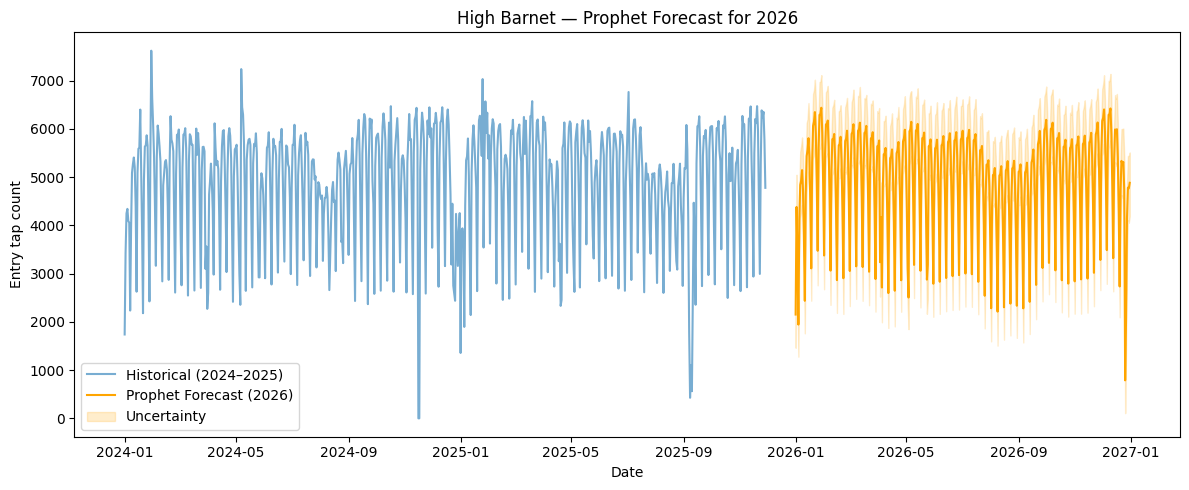

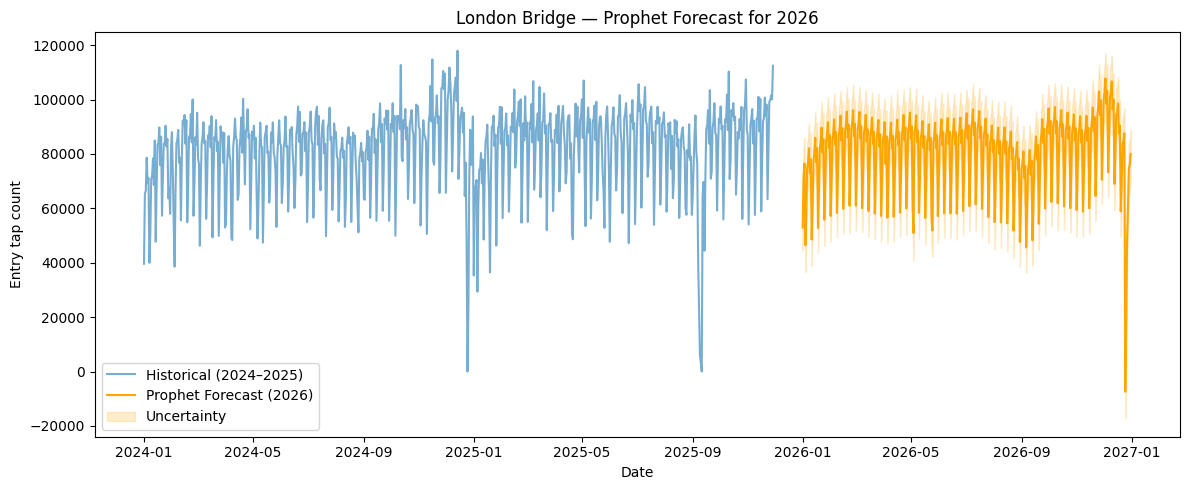

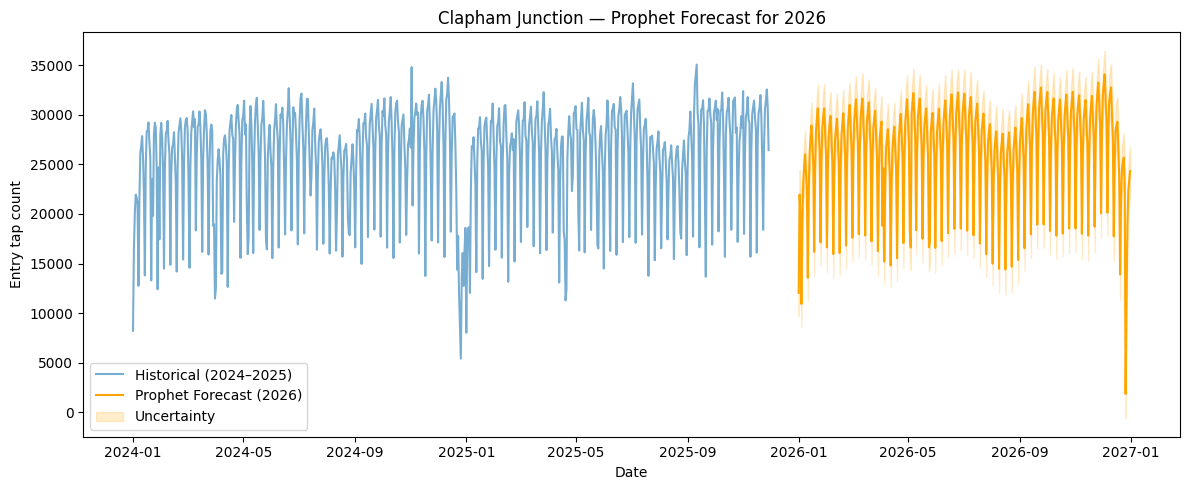

In [42]:
import matplotlib.pyplot as plt

for cluster, ts in df_ts.items():
    station = representatives[cluster]
    forecast = prophet_forecasts[cluster]["forecast"]

    plt.figure(figsize=(12,5))

    # historical
    plt.plot(ts.index, ts['EntryTapCount'], label='Historical (2024–2025)', alpha=0.6)

    # prophet forecast
    plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast (2026)', color='orange')

    # uncertainty interval
    plt.fill_between(
        forecast['ds'],
        forecast['yhat_lower'],
        forecast['yhat_upper'],
        color='orange', alpha=0.2, label='Uncertainty'
    )

    plt.title(f"{station} — Prophet Forecast for 2026")
    plt.xlabel("Date")
    plt.ylabel("Entry tap count")
    plt.legend()
    plt.tight_layout()
    plt.show()

## 5) Anomaly Detection:

Finally, after completing the forecasting for the 3 representative stations, we will now return back to the original dataset and attempt to identify and anomalous results and unusual patterns.

In [43]:
df['TravelDate'] = pd.to_datetime(df['TravelDate'])
daily = df.groupby(['Station', 'TravelDate'])[['EntryTapCount','ExitTapCount']].sum()
daily = daily.reset_index()
print(daily.shape)
daily.head()

(299860, 4)


,Station,TravelDate,EntryTapCount,ExitTapCount
0,Abbey Road DLR,2024-01-01,395,375
1,Abbey Road DLR,2024-01-02,689,661
2,Abbey Road DLR,2024-01-03,781,797
3,Abbey Road DLR,2024-01-04,859,848
4,Abbey Road DLR,2024-01-05,844,783


In [72]:
from statsmodels.tsa.seasonal import STL

def stl_decompose_station(df_station):
    df_station = df_station.set_index('TravelDate').sort_index()
    series = df_station['EntryTapCount']
    stl = STL(series, period=7, robust=True)
    result = stl.fit()
    
    df_station['trend'] = result.trend
    df_station['seasonal'] = result.seasonal
    df_station['residual'] = result.resid

    return df_station

sample_station = "Clapham Junction"
df_sample = daily[daily['Station'] == sample_station].copy()
df_sample_decomp = stl_decompose_station(df_sample)

df_sample_decomp.head()

,Station,EntryTapCount,ExitTapCount,trend,seasonal,residual
TravelDate,,,,,,
2024-01-01,Clapham Junction,8223,9027,14458.566308,-6209.325481,-26.240827
2024-01-02,Clapham Junction,16527,16971,15338.195960,1117.953743,70.850297
2024-01-03,Clapham Junction,20092,20522,16212.539858,4205.577214,-326.117072
2024-01-04,Clapham Junction,21939,22431,17080.130538,4984.925574,-126.056112
2024-01-05,Clapham Junction,21668,21976,17940.521843,3155.137288,572.340869


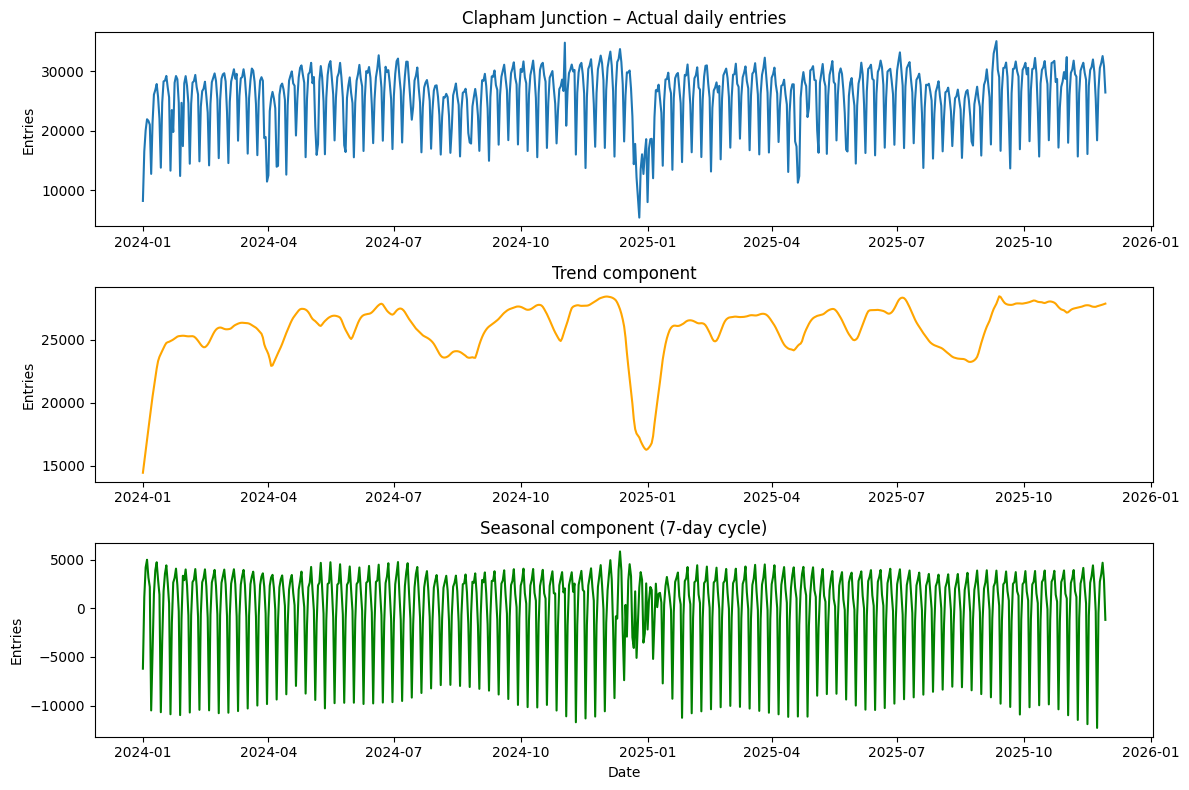

In [73]:
plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
plt.plot(df_sample_decomp.index, df_sample_decomp['EntryTapCount'], label='Actual')
plt.title(f"{sample_station} – Actual daily entries")
plt.ylabel("Entries")

plt.subplot(3,1,2)
plt.plot(df_sample_decomp.index, df_sample_decomp['trend'], label='Trend', color='orange')
plt.title("Trend component")
plt.ylabel("Entries")

plt.subplot(3,1,3)
plt.plot(df_sample_decomp.index, df_sample_decomp['seasonal'], label='Seasonal (weekly)', color='green')
plt.title("Seasonal component (7-day cycle)")
plt.ylabel("Entries")
plt.xlabel("Date")

plt.tight_layout()
plt.show()

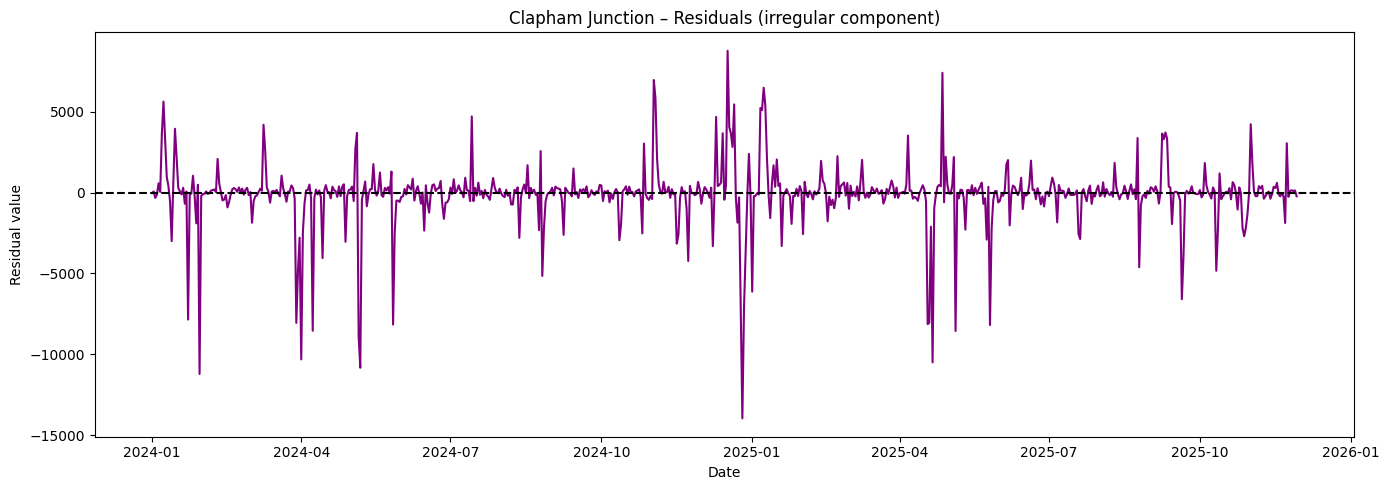

In [74]:
plt.figure(figsize=(14,5))
plt.plot(df_sample_decomp.index, df_sample_decomp['residual'], color='purple')
plt.title(f"{sample_station} – Residuals (irregular component)")
plt.xlabel("Date")
plt.ylabel("Residual value")
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

In [75]:
def detect_anomalies(df_station_decomp, threshold=3.5):
    """
    Detect anomalies using the Median Absolute Deviation (MAD) method.
    threshold: larger = fewer anomalies, smaller = more sensitive
    """
    residuals = df_station_decomp['residual']

    # Compute MAD
    median = residuals.median()
    mad = np.median(np.abs(residuals - median))

    # Robust Z-score
    robust_z = 0.6745 * (residuals - median) / mad

    df_station_decomp['anomaly_score'] = robust_z.abs()
    df_station_decomp['is_anomaly'] = df_station_decomp['anomaly_score'] > threshold

    return df_station_decomp

df_sample_anoms = detect_anomalies(df_sample_decomp, threshold=3.5)

df_sample_anoms[df_sample_anoms['is_anomaly']].head()


,Station,EntryTapCount,ExitTapCount,trend,seasonal,residual,anomaly_score,is_anomaly
TravelDate,,,,,,,,
2024-01-07,Clapham Junction,12764,14032,19643.841005,-10499.960253,3620.119248,8.587608,True
2024-01-08,Clapham Junction,21376,21895,20492.593313,-4748.403919,5631.810606,13.371440,True
2024-01-09,Clapham Junction,26089,26263,21252.087812,1466.461833,3370.450355,7.993891,True
2024-01-13,Clapham Junction,22036,22787,23638.983889,1395.479845,-2998.463734,7.151483,True
2024-01-15,Clapham Junction,24723,24682,24109.890756,-3335.864950,3948.974194,9.369630,True


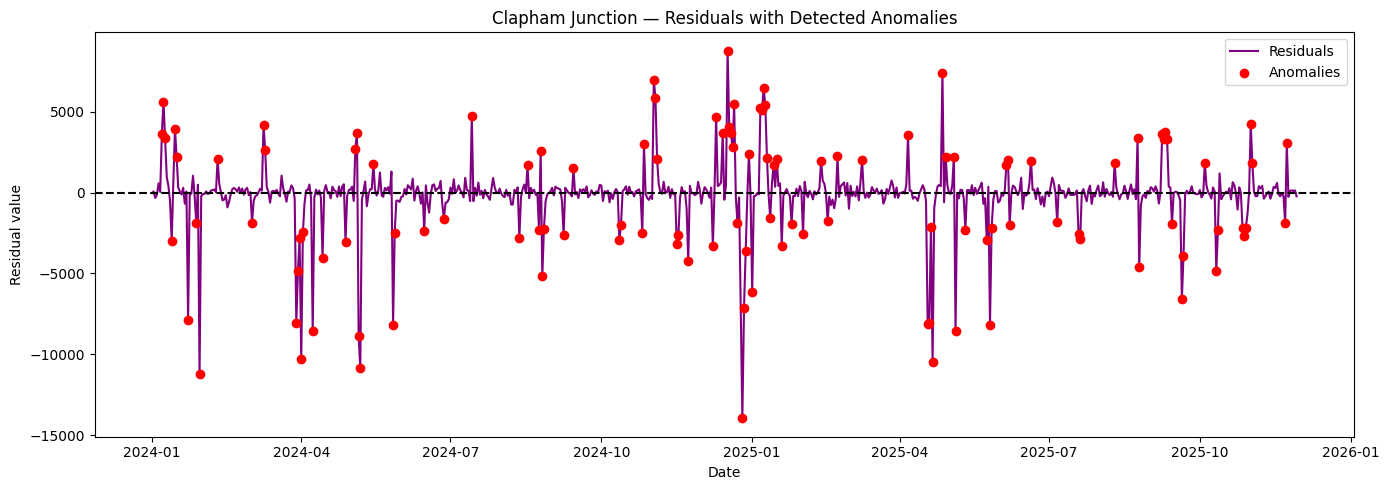

In [77]:
plt.figure(figsize=(14,5))
plt.plot(df_sample_anoms.index, df_sample_anoms['residual'], color='purple', label="Residuals")

# Highlight anomalies
anoms = df_sample_anoms[df_sample_anoms['is_anomaly']]
plt.scatter(anoms.index, anoms['residual'], color='red', label='Anomalies', zorder=5)

plt.axhline(0, color='black', linestyle='--')
plt.title(f"{sample_station} — Residuals with Detected Anomalies")
plt.xlabel("Date")
plt.ylabel("Residual value")
plt.legend()
plt.tight_layout()
plt.show()

Just realised we didnt take into account the exit data and the above anomaly graphing just takes into account entry tap data. So we will now move to a combined approach

In [78]:
def stl_decompose_station_both(df_station):
    """
    Run STL decomposition for BOTH EntryTapCount and ExitTapCount.
    Returns df with: entry_trend, entry_seasonal, entry_residual,
                     exit_trend, exit_seasonal, exit_residual
    """
    df_station = df_station.set_index("TravelDate").sort_index()

    # ----- ENTRY -----
    entry_series = df_station["EntryTapCount"]
    stl_entry = STL(entry_series, period=7, robust=True).fit()
    df_station["entry_trend"] = stl_entry.trend
    df_station["entry_seasonal"] = stl_entry.seasonal
    df_station["entry_residual"] = stl_entry.resid

    # ----- EXIT -----
    exit_series = df_station["ExitTapCount"]
    stl_exit = STL(exit_series, period=7, robust=True).fit()
    df_station["exit_trend"] = stl_exit.trend
    df_station["exit_seasonal"] = stl_exit.seasonal
    df_station["exit_residual"] = stl_exit.resid

    return df_station


In [ ]:
def detect_anomalies_combined(df, threshold=3):
    """
    Detect anomalies on entry and exit residuals using MAD.
    Adds columns:
        entry_z, exit_z, combined_anomaly (True/False)
    """
    # ENTRY
    entry_res = df["entry_residual"]
    entry_med = np.median(entry_res)
    entry_mad = np.median(np.abs(entry_res - entry_med))
    entry_z = 0.6745 * (entry_res - entry_med) / entry_mad
    df["entry_z"] = entry_z

    # EXIT
    exit_res = df["exit_residual"]
    exit_med = np.median(exit_res)
    exit_mad = np.median(np.abs(exit_res - exit_med))
    exit_z = 0.6745 * (exit_res - exit_med) / exit_mad
    df["exit_z"] = exit_z

    # COMBINED — flagged if EITHER entry or exit is unusual
    df["combined_anomaly"] = (np.abs(entry_z) > threshold) | (np.abs(exit_z) > threshold)

    return df

In [88]:
station = "Clapham Junction"

df_station = daily[daily["Station"] == station].copy()
df_decomp = stl_decompose_station_both(df_station)
df_anoms = detect_anomalies_combined(df_decomp)

df_anoms.head()

,Station,EntryTapCount,ExitTapCount,entry_trend,entry_seasonal,entry_residual,exit_trend,exit_seasonal,exit_residual,entry_z,exit_z,combined_anomaly
TravelDate,,,,,,,,,,,,
2024-01-01,Clapham Junction,8223,9027,14458.566308,-6209.325481,-26.240827,15919.209769,-6878.562139,-13.647630,-0.083492,-0.102794,False
2024-01-02,Clapham Junction,16527,16971,15338.195960,1117.953743,70.850297,16526.613690,369.682119,74.704191,0.147392,0.146506,False
2024-01-03,Clapham Junction,20092,20522,16212.539858,4205.577214,-326.117072,17134.635993,3319.570238,67.793769,-0.796602,0.127007,False
2024-01-04,Clapham Junction,21939,22431,17080.130538,4984.925574,-126.056112,17742.765656,4985.593600,-297.359256,-0.320854,-0.903338,False
2024-01-05,Clapham Junction,21668,21976,17940.521843,3155.137288,572.340869,18350.088870,3421.527852,204.383279,1.339945,0.512419,False


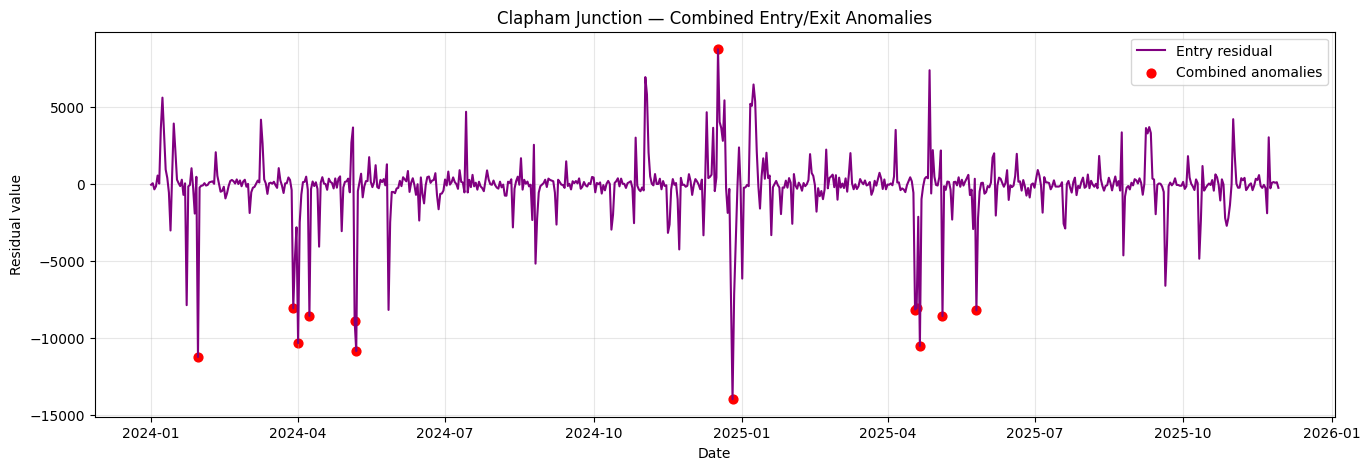

In [89]:
anom_points = df_anoms[df_anoms["combined_anomaly"]]

plt.figure(figsize=(16,5))
plt.plot(df_anoms.index, df_anoms["entry_residual"], label="Entry residual", color="purple")
plt.scatter(anom_points.index, anom_points["entry_residual"],
            color="red", label="Combined anomalies", s=40)

plt.title(f"{station} — Combined Entry/Exit Anomalies")
plt.xlabel("Date")
plt.ylabel("Residual value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 5) Percentile based Anomaly approach
 It seems as though this error detection method using MADS and Z scores is too sensitive, it requires threshold values of 10-20 to get any sort of results that seem sensible. We will now shift to a percentile based approach. This approach will allow us to see any anomaly heavy days.

In [93]:
def detect_anomalies_percentile_combined(df, upper_pct=0.99, lower_pct=0.01):
    """
    Flags combined anomalies based on entry and exit residual percentiles.
    An anomaly occurs if either entry_residual or exit_residual
    falls in the top or bottom percentile range.
    """

    # Percentile thresholds for ENTRY residuals
    upper_e = df['entry_residual'].quantile(upper_pct)
    lower_e = df['entry_residual'].quantile(lower_pct)

    # Percentile thresholds for EXIT residuals
    upper_x = df['exit_residual'].quantile(upper_pct)
    lower_x = df['exit_residual'].quantile(lower_pct)

    # Combined anomaly: flag if ANY of these conditions hold
    df['combined_anomaly'] = (
        (df['entry_residual'] > upper_e) |
        (df['entry_residual'] < lower_e) |
        (df['exit_residual'] > upper_x) |
        (df['exit_residual'] < lower_x)
    )

    return df


In [94]:
all_results = []
upper_pct = 0.99
lower_pct = 0.01

for station_name in daily["Station"].unique():

    # Extract station daily data
    df_station = daily[daily["Station"] == station_name].copy()

    # STL decomposition for both entry + exit
    df_decomp = stl_decompose_station_both(df_station)

    # Apply percentile-based anomalies
    df_anoms = detect_anomalies_percentile_combined(df_decomp, upper_pct, lower_pct)

    # Add station name for grouping
    df_anoms["Station"] = station_name

    all_results.append(df_anoms)

# Combine all stations
all_stations_df = pd.concat(all_results).sort_index()


In [96]:
all_stations_df.head()

,Station,EntryTapCount,ExitTapCount,entry_trend,entry_seasonal,entry_residual,exit_trend,exit_seasonal,exit_residual,combined_anomaly
TravelDate,,,,,,,,,,
2024-01-01,Abbey Road DLR,395,375,630.751255,125.462285,-361.213540,609.645982,91.979686,-326.625668,False
2024-01-01,Kings Cross St Pancras,67203,66407,77538.345774,-10701.497934,366.152160,75928.546299,-10571.650356,1050.104057,False
2024-01-01,Walthamstow Central,8036,8687,14741.220648,-1779.003464,-4926.217184,14400.470990,-1334.453454,-4379.017537,False
2024-01-01,Kingsbury,2133,2256,2966.928622,-431.715264,-402.213357,3506.935449,-78.667780,-1172.267669,False
2024-01-01,Crystal Palace,1104,1254,2066.433882,-981.237443,18.803561,2159.152696,-925.595656,20.442960,False


In [ ]:
station_anomaly_counts = (
    all_stations_df.groupby("Station")["combined_anomaly"]
    .sum()
    .sort_values(ascending=False)
)

display(station_anomaly_counts.head(15))

Station
Mornington Crescent    25
North Ealing           25
Bushey                 24
Arsenal                24
Marble Arch            23
Prince Regent          23
Euston NR              23
Hanwell                23
Camden Town            22
Hatton Cross           22
Holloway Road          22
Osterley               22
Chorleywood            22
Walthamstow Central    22
Grange Hill            22
Name: combined_anomaly, dtype: int64

In [98]:
date_anomaly_counts = (
    all_stations_df[all_stations_df["combined_anomaly"] == True]
    .groupby("TravelDate")
    .size()
    .sort_values(ascending=False)
)

date_anomaly_counts.head(20)

TravelDate
2025-09-11    210
2025-09-09    201
2024-12-26    181
2025-09-10    177
2024-05-06    164
2025-09-08    148
2025-01-01    141
2025-04-21    100
2025-05-05     99
2025-09-04     82
2025-09-05     79
2024-12-17     77
2024-12-24     71
2025-09-07     67
2024-10-27     62
2025-05-31     61
2024-05-27     61
2025-01-08     61
2025-09-06     60
2025-05-26     59
dtype: int64

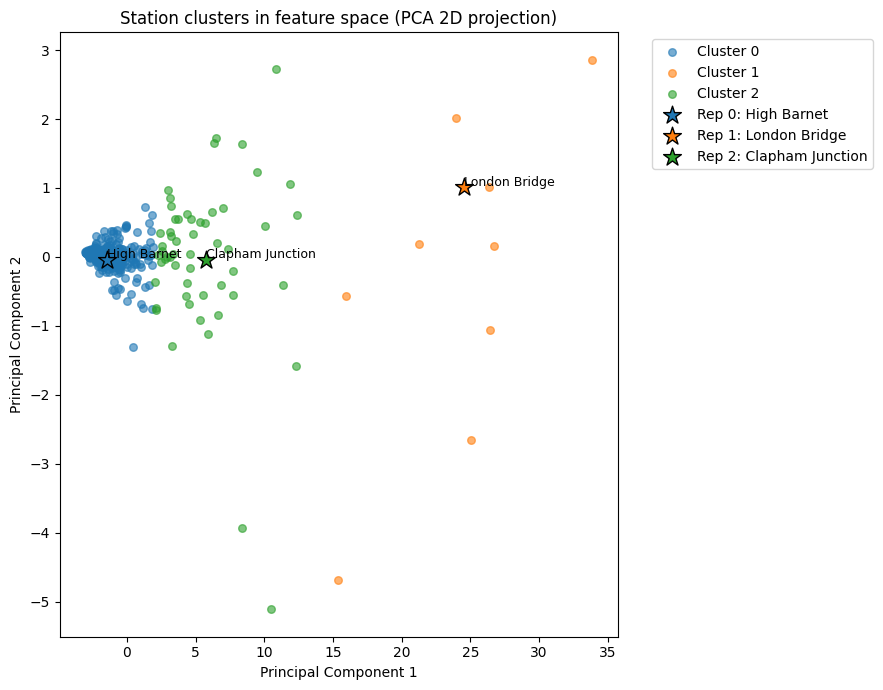

In [102]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# ---- Parameters ----
K = 3  # number of clusters you finally chose (2 or 3 or 4)
labels = cluster_results[K]['labels']     # cluster label for each station
stations = features_clean.index          # station names

# ---- 1. Project the 22-D features into 2-D using PCA ----
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)   # shape: (437, 2)

# Build a plotting DataFrame
plot_df = pd.DataFrame({
    'Station': stations,
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': labels
})

# ---- 2. Scatter plot of stations coloured by cluster ----
plt.figure(figsize=(9, 7))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

for c in range(K):
    subset = plot_df[plot_df['Cluster'] == c]
    plt.scatter(
        subset['PC1'],
        subset['PC2'],
        s=30,
        alpha=0.6,
        color=colors[c],
        label=f"Cluster {c}"
    )

# ---- 3. Highlight representative stations ----
for c, rep_name in representatives.items():
    rep_row = plot_df[plot_df['Station'] == rep_name]
    if not rep_row.empty:
        x = rep_row['PC1'].values[0]
        y = rep_row['PC2'].values[0]
        plt.scatter(x, y,
                    s=180,
                    color=colors[c],
                    edgecolors='black',
                    marker='*',
                    label=f"Rep {c}: {rep_name}")
        plt.text(x + 0.02, y + 0.02, rep_name, fontsize=9)

plt.title("Station clusters in feature space (PCA 2D projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [103]:
representatives

{0: 'High Barnet', 1: 'London Bridge', 2: 'Clapham Junction'}

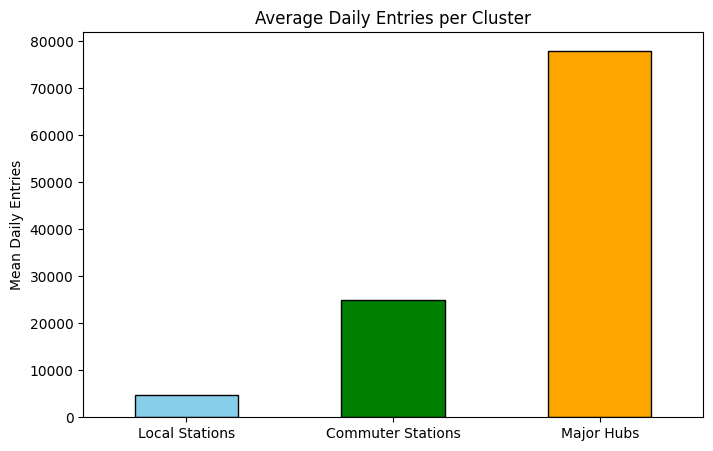

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Prepare average entries per cluster ---
daily_with_labels = daily.merge(
    pd.DataFrame({"Station": stations, "Cluster": cluster_results[3]["labels"]}),
    on="Station",
    how="left"
)

avg_by_cluster = (
    daily_with_labels.groupby("Cluster")["EntryTapCount"]
    .mean()
    .reindex([0,2,1])
)

# --- Plot ---
plt.figure(figsize=(8,5))
colors = ['skyblue', 'green', 'orange']

avg_by_cluster.plot(
    kind='bar',
    color=colors,
    edgecolor='black'
)

plt.title("Average Daily Entries per Cluster")
plt.xlabel("")
plt.ylabel("Mean Daily Entries")
plt.xticks([0,1,2], ["Local Stations", "Commuter Stations", "Major Hubs"], rotation=0)
plt.show()


C:\Users\suhai\AppData\Local\Temp\ipykernel_25496\1444000702.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


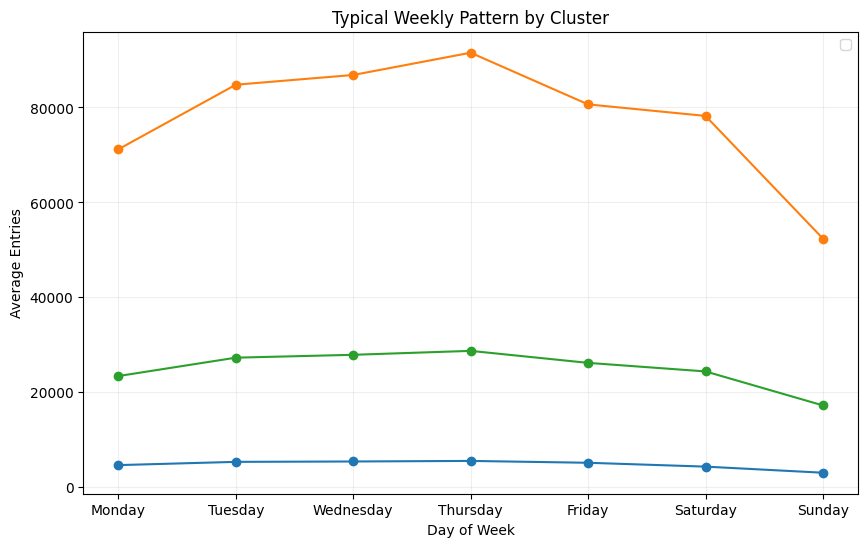

In [121]:
# --- Compute average weekday pattern for each cluster ---
daily_with_labels["DayName"] = daily_with_labels["TravelDate"].dt.day_name()

weekday_means = (
    daily_with_labels
    .groupby(["Cluster", "DayName"])["EntryTapCount"]
    .mean()
    .unstack(0)
)

# Reorder weekdays
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekday_means = weekday_means.reindex(weekday_order)

# --- Plot ---
plt.figure(figsize=(10,6))

plt.plot(weekday_means.index, weekday_means[0], marker='o')
plt.plot(weekday_means.index, weekday_means[1], marker='o')
plt.plot(weekday_means.index, weekday_means[2], marker='o')

plt.title("Typical Weekly Pattern by Cluster")
plt.ylabel("Average Entries")
plt.xlabel("Day of Week")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


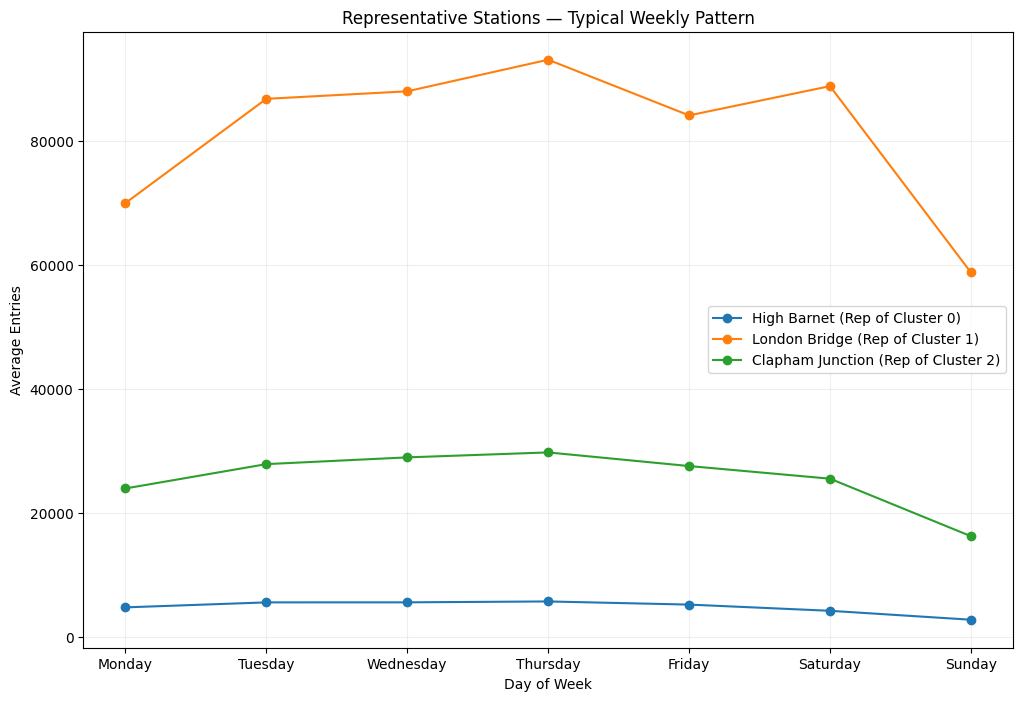

In [122]:
rep_stations = {
    0: "High Barnet",
    1: "London Bridge",
    2: "Clapham Junction"
}

plt.figure(figsize=(12,8))

for cluster_id, station_name in rep_stations.items():
    df_rep = daily[daily["Station"] == station_name].copy()
    df_rep["DayName"] = df_rep["TravelDate"].dt.day_name()
    
    station_week = (
        df_rep.groupby("DayName")["EntryTapCount"].mean()
        .reindex(weekday_order)
    )
    
    plt.plot(
        station_week.index,
        station_week.values,
        marker='o',
        label=f"{station_name} (Rep of Cluster {cluster_id})"
    )

plt.title("Representative Stations — Typical Weekly Pattern")
plt.ylabel("Average Entries")
plt.xlabel("Day of Week")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

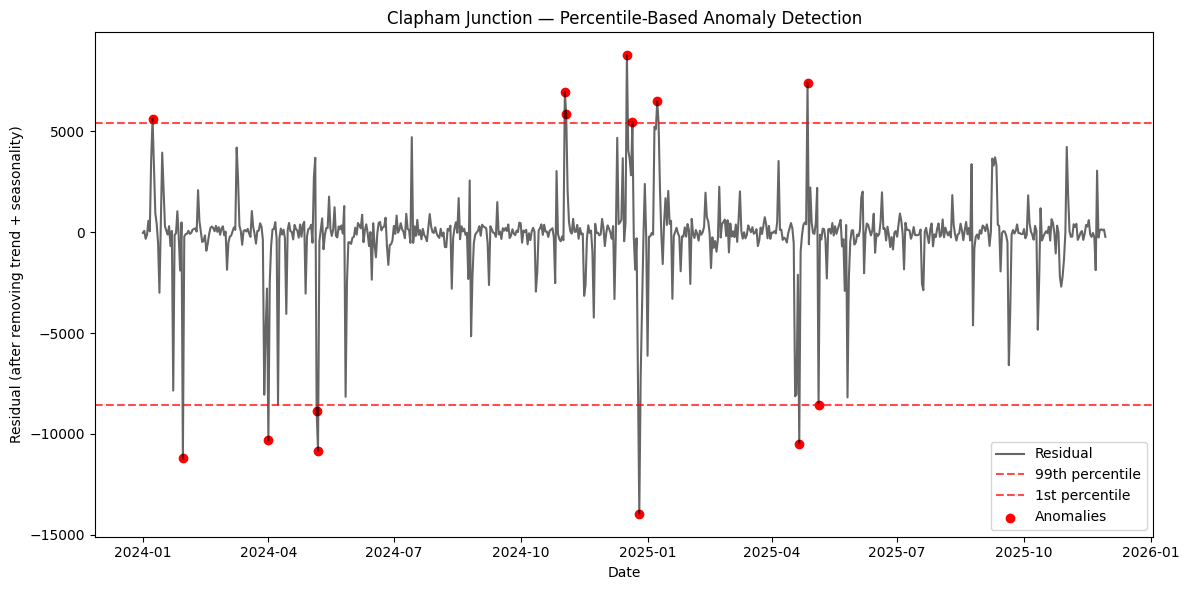

In [123]:
import matplotlib.pyplot as plt

# Filter Clapham Junction
station_name = "Clapham Junction"
df_cj = daily[daily["Station"] == station_name].copy()

# Decompose using your existing STL function
df_cj_dec = stl_decompose_station_both(df_cj)

# Compute percentile thresholds
lower = df_cj_dec["entry_residual"].quantile(0.01)
upper = df_cj_dec["entry_residual"].quantile(0.99)

# Identify anomalies
df_cj_dec["anomaly"] = (df_cj_dec["entry_residual"] < lower) | (df_cj_dec["entry_residual"] > upper)

# ---- Plot: Residuals + anomalies ----
plt.figure(figsize=(12,6))

plt.plot(df_cj_dec.index, df_cj_dec["entry_residual"], label="Residual", color="black", alpha=0.6)
plt.axhline(upper, color="red", linestyle="--", alpha=0.7, label="99th percentile")
plt.axhline(lower, color="red", linestyle="--", alpha=0.7, label="1st percentile")

# Highlight anomalies
anoms = df_cj_dec[df_cj_dec["anomaly"]]
plt.scatter(anoms.index, anoms["entry_residual"], color="red", label="Anomalies")

plt.title("Clapham Junction — Percentile-Based Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Residual (after removing trend + seasonality)")
plt.legend()
plt.tight_layout()
plt.show()


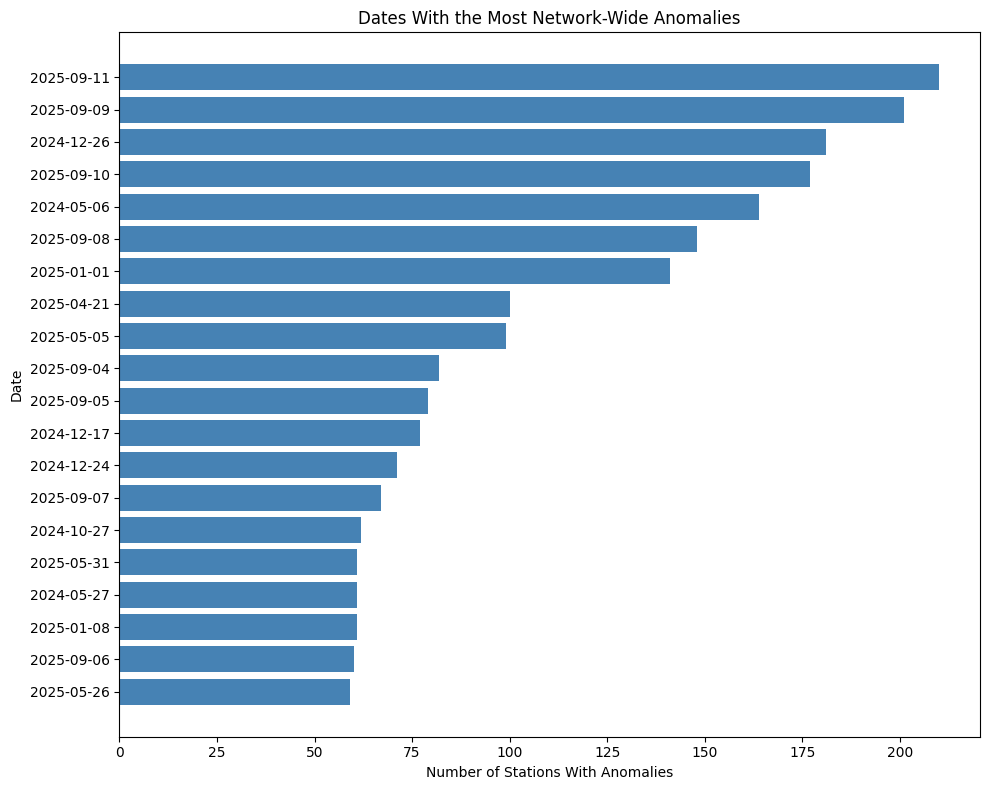

In [129]:
import matplotlib.pyplot as plt
import pandas as pd

# Create the provided anomaly counts table
data = {
    "Date": [
        "2025-09-11","2025-09-09","2024-12-26","2025-09-10","2024-05-06",
        "2025-09-08","2025-01-01","2025-04-21","2025-05-05","2025-09-04",
        "2025-09-05","2024-12-17","2024-12-24","2025-09-07","2024-10-27",
        "2025-05-31","2024-05-27","2025-01-08","2025-09-06","2025-05-26"
    ],
    "Count": [
        210,201,181,177,164,
        148,141,100,99,82,
        79,77,71,67,62,
        61,61,61,60,59
    ]
}

df_dates = pd.DataFrame(data)
df_dates["Date"] = pd.to_datetime(df_dates["Date"])
df_dates = df_dates.sort_values("Count")  # Sort for better horizontal bar layout

# ---- Plot ----
plt.figure(figsize=(10,8))
plt.barh(df_dates["Date"].dt.strftime("%Y-%m-%d"), df_dates["Count"], color="steelblue")



plt.title("Dates With the Most Network-Wide Anomalies")
plt.xlabel("Number of Stations With Anomalies")
plt.ylabel("Date")
plt.tight_layout()
plt.show()

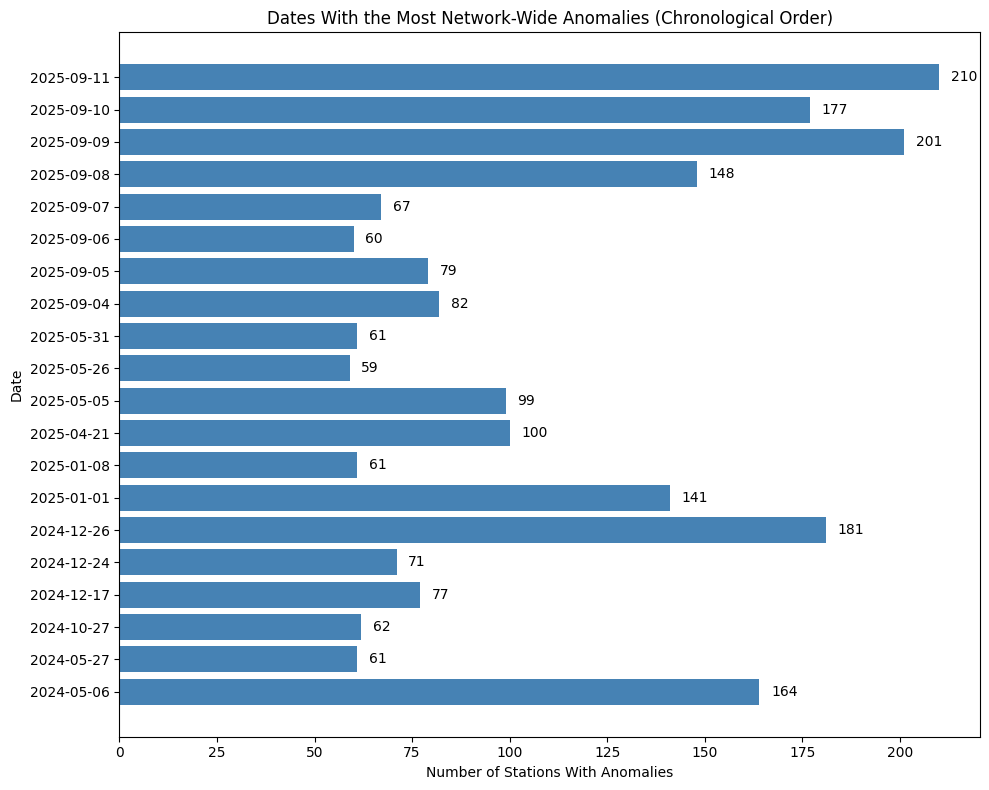

In [127]:
# Original anomaly data
data = {
    "Date": [
        "2024-05-06","2024-05-27","2024-10-27","2024-12-17","2024-12-24",
        "2024-12-26","2025-01-01","2025-01-08","2025-04-21","2025-05-05",
        "2025-05-26","2025-05-31","2025-09-04","2025-09-05","2025-09-06",
        "2025-09-07","2025-09-08","2025-09-09","2025-09-10","2025-09-11"
    ],
    "Count": [
        164,61,62,77,71,
        181,141,61,100,99,
        59,61,82,79,60,
        67,148,201,177,210
    ]
}

df_dates = pd.DataFrame(data)
df_dates["Date"] = pd.to_datetime(df_dates["Date"])

# Sort chronologically
df_dates = df_dates.sort_values("Date")

# --- Plot ---
plt.figure(figsize=(10,8))
bars = plt.barh(df_dates["Date"].dt.strftime("%Y-%m-%d"), df_dates["Count"], color="steelblue")

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 3,                         # X position slightly beyond bar
        bar.get_y() + bar.get_height()/2, # Y position centered on bar
        str(width),                        # Text = value
        va='center'
    )

plt.title("Dates With the Most Network-Wide Anomalies (Chronological Order)")
plt.xlabel("Number of Stations With Anomalies")
plt.ylabel("Date")
plt.tight_layout()
plt.show()